In [2]:
import os
import zipfile
import subprocess
import shutil

# Step 1: Set Kaggle API Key location
kaggle_json_path = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_json_path, exist_ok=True)

# NOTE: Adjust this if your kaggle.json is in the notebook folder
local_kaggle_json = "kaggle.json"

if not os.path.exists(local_kaggle_json):
    raise FileNotFoundError("⚠️ kaggle.json not found in the notebook directory!")

# Move kaggle.json to ~/.kaggle and set permissions
shutil.copy(local_kaggle_json, os.path.join(kaggle_json_path, "kaggle.json"))
os.chmod(os.path.join(kaggle_json_path, "kaggle.json"), 0o600)

# Step 2: Create data directory
data_path = "../data/breakhis"  # Going one level up from notebooks/
os.makedirs(data_path, exist_ok=True)

# Step 3: Run Kaggle CLI to download and unzip
subprocess.run([
    "kaggle", "datasets", "download",
    "-d", "ambarish/breakhis",
    "-p", data_path,
    "--unzip"
], check=True)


Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown


KeyboardInterrupt: 

In [1]:
import os
import pandas as pd
from glob import glob

# Set dataset root path
dataset_root = "../data/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"

# Sanity check
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"❌ Dataset path not found: {dataset_root}")

# Get all image paths (recursive across magnifications)
image_paths = glob(os.path.join(dataset_root, "*", "*", "*", "*", "*", "*.png"))
print(f"🔍 Found {len(image_paths)} .png files")


# Parse image paths to extract metadata
data = []

for path in image_paths:
    parts = path.split(os.sep)
    try:
        label_type = parts[-6]         # 'malignant' or 'benign'
        subclass = parts[-4]           # e.g. 'mucinous_carcinoma'
        magnification = parts[-2]      # e.g. '100X'
        filename = os.path.basename(path)

        data.append({
            "path": path,
            "label_type": label_type,
            "subclass": subclass,
            "magnification": magnification,
            "filename": filename
        })
    except IndexError:
        print(f"❗ Skipping malformed path: {path}")

# Convert to DataFrame
metadata = pd.DataFrame(data)

# Display basic metadata
print("\n✅ Sample entries:")
print(metadata.head())

print("\n📊 Subclass distribution:")
print(metadata["subclass"].value_counts())

print("\n🔬 Magnification distribution:")
print(metadata["magnification"].value_counts())

print("\n🏷️ Label type distribution:")
print(metadata["label_type"].value_counts())


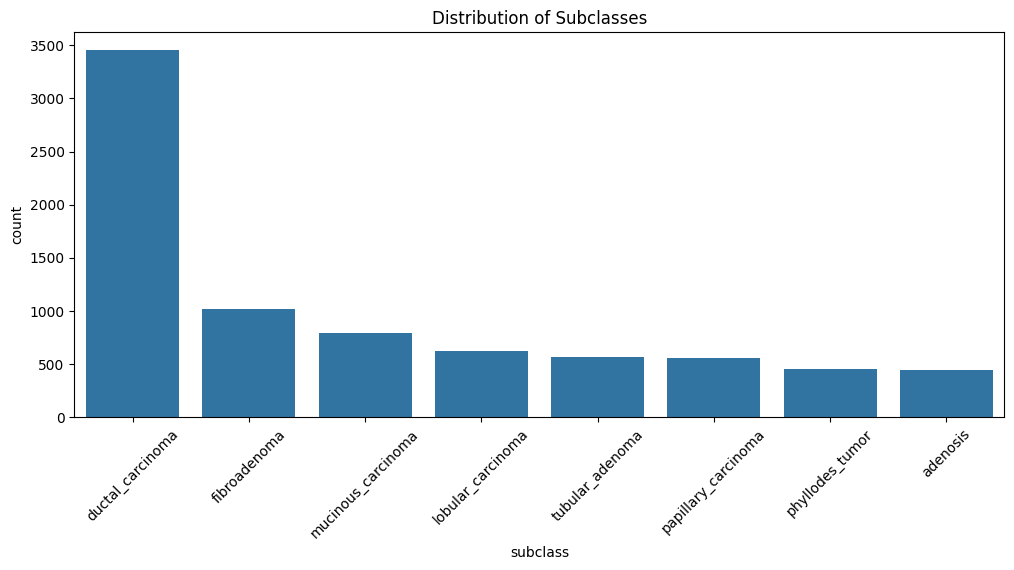

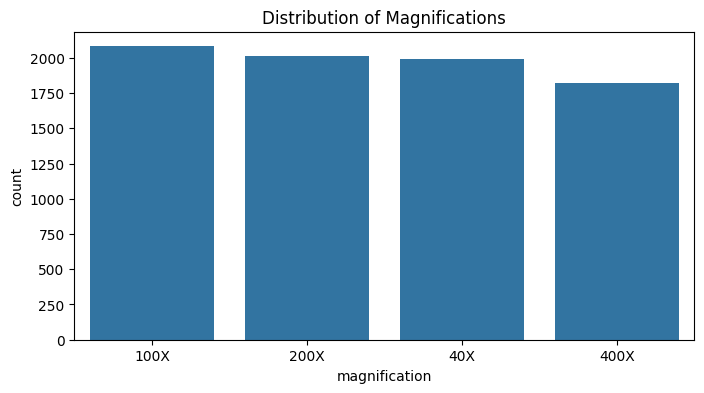

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot subclass distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=metadata, x="subclass", order=metadata["subclass"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Subclasses")
plt.show()

# Plot magnification distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=metadata, x="magnification", order=metadata["magnification"].value_counts().index)
plt.title("Distribution of Magnifications")
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

# Extract patient ID
def extract_patient_id(path):
    filename = os.path.basename(path)
    return filename.split("_")[2]

metadata["patient_id"] = metadata["path"].apply(extract_patient_id)

# Get unique patient per subclass
unique_patients = metadata[["patient_id", "subclass"]].drop_duplicates()

# Train-test-val split (stratified on subclass)
train_ids, test_ids = train_test_split(
    unique_patients,
    test_size=0.15,
    stratify=unique_patients["subclass"],
    random_state=42
)

train_ids, val_ids = train_test_split(
    train_ids,
    test_size=0.15 / 0.85,
    stratify=train_ids["subclass"],
    random_state=42
)

# Map to full metadata
train_df = metadata[metadata["patient_id"].isin(train_ids["patient_id"])]
val_df = metadata[metadata["patient_id"].isin(val_ids["patient_id"])]
test_df = metadata[metadata["patient_id"].isin(test_ids["patient_id"])]


In [8]:
import numpy as np
import torch
from collections import Counter

# 1. Count training examples per class
class_counts = Counter(train_df["subclass"])
classes = sorted(class_counts.keys())  # Ensure consistent order

# 2. Create mappings
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

# 3. Safely map class labels to indices in all splits
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df.loc[:, "class_idx"] = train_df["subclass"].map(class_to_idx)
val_df.loc[:, "class_idx"] = val_df["subclass"].map(class_to_idx)
test_df.loc[:, "class_idx"] = test_df["subclass"].map(class_to_idx)

# 4. Compute class weights = inverse frequency
total = sum(class_counts.values())
class_weights = np.array([total / class_counts[cls] for cls in classes], dtype=np.float32)

# 5. Normalize to sum to 1
class_weights = class_weights / class_weights.sum()

# 6. Convert to PyTorch tensor
class_weights_tensor = torch.FloatTensor(class_weights)

# 7. Print for confirmation
print("Class to Index Mapping:", class_to_idx)
print("Class Weights Tensor:", class_weights_tensor)


Class to Index Mapping: {'adenosis': 0, 'ductal_carcinoma': 1, 'fibroadenoma': 2, 'lobular_carcinoma': 3, 'mucinous_carcinoma': 4, 'papillary_carcinoma': 5, 'phyllodes_tumor': 6, 'tubular_adenoma': 7}
Class Weights Tensor: tensor([0.1859, 0.0239, 0.0812, 0.1316, 0.1040, 0.1470, 0.1818, 0.1445])


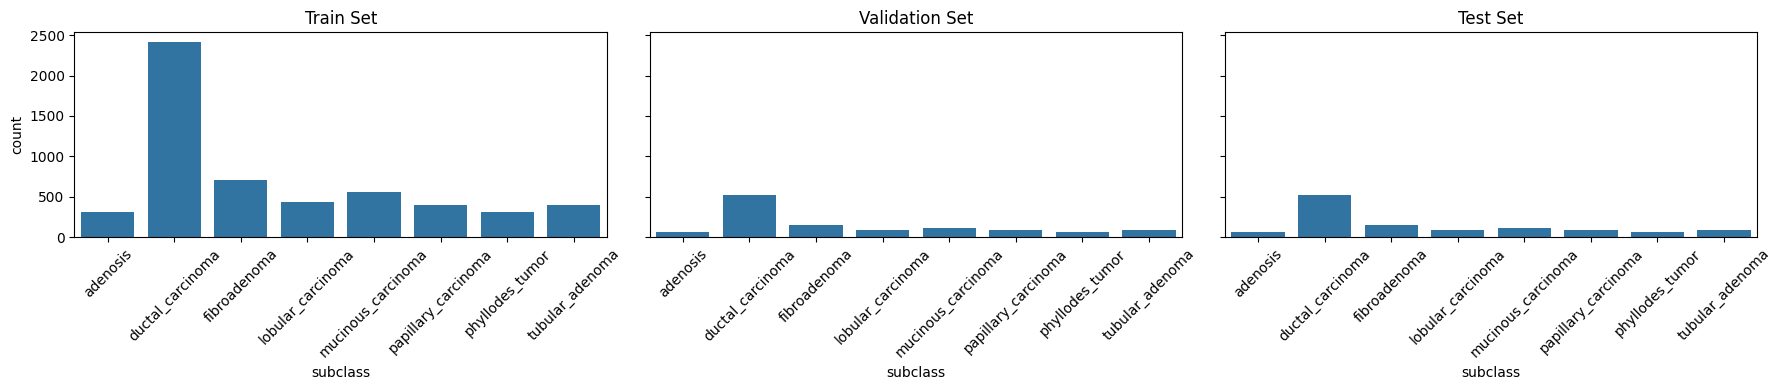

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot function
def plot_split_distribution(df_list, df_names, label_col="subclass"):
    fig, axes = plt.subplots(1, len(df_list), figsize=(18, 4), sharey=True)
    for i, (df, name) in enumerate(zip(df_list, df_names)):
        sns.countplot(data=df, x=label_col, order=sorted(df[label_col].unique()), ax=axes[i])
        axes[i].set_title(f"{name} Set")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_split_distribution(
    [train_df, val_df, test_df],
    ["Train", "Validation", "Test"]
)


In [11]:
from torch.utils.data import WeightedRandomSampler

# Get the sample weights for each image in the training dataset
sample_weights = train_df["class_idx"].map(lambda x: class_weights_tensor[x]).values

# Create the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Keep it same as dataset length
    replacement=True
)

# We'll later pass this `sampler` to the PyTorch DataLoader for the training set


In [12]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Custom Dataset class
class BreakHisDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label = self.df.loc[idx, "class_idx"]
        
        # Load image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets
train_dataset = BreakHisDataset(train_df, transform=train_transform)
val_dataset = BreakHisDataset(val_df, transform=test_transform)
test_dataset = BreakHisDataset(test_df, transform=test_transform)

# DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


ModuleNotFoundError: No module named '_lzma'